# Translational mapping

In this notebook we explicitely model the link between the regulatory and structural embeddings of the U2OS cells and evaluate their generalizability.

---


## 0. Enviromental setup

We first load the required packages and define a number of helper functions.

In [31]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import (
    train_test_split,
    GroupShuffleSplit,
    LeaveOneGroupOut,
)
from torch.utils.data import DataLoader, TensorDataset
import torch
from torch import nn
from torch.optim import Adam
from tqdm import tqdm
import copy
from sklearn.neighbors import NearestNeighbors
from collections import Counter


seed = 1234

device = "cpu"

%load_ext nb_black

The nb_black extension is already loaded. To reload it, use:
  %reload_ext nb_black


<IPython.core.display.Javascript object>

In [53]:
def train_model(
    model,
    optimizer,
    criterion,
    data_dict,
    n_epochs=1000,
    early_stopping=50,
    device="cpu",
):

    best_val_loss = np.infty
    best_epoch = 0
    best_model_weights = None
    es_counter = 0

    for i in range(n_epochs):
        if es_counter > early_stopping:
            break
        for mode in ["train", "val"]:
            loss = process_single_epoch(
                model=model,
                optimizer=optimizer,
                criterion=criterion,
                data=data_dict[mode],
                mode=mode,
            )
            # print("{} loss: {}".format(mode.upper(), loss))

            if mode == "val":
                if loss < best_val_loss:
                    best_val_loss = loss
                    best_epoch = i
                    best_model_weights = copy.deepcopy(model.state_dict())
                else:
                    es_counter += 1

    model.load_state_dict(best_model_weights)

    for mode in ["train", "val", "test"]:
        loss = process_single_epoch(
            model, optimizer, criterion, data_dict[mode], "test"
        )
        print("{} loss: {}".format(mode.upper(), loss))

    return model


def process_single_epoch(model, optimizer, criterion, data, mode, device="cpu"):
    total_loss = 0
    model.to(device)
    if mode == "train":
        model.train()
        optimizer.zero_grad()
    else:
        model.eval()

    for inputs, labels, _ in data:
        inputs = inputs.type(torch.FloatTensor).to(device)
        labels = labels.type(torch.FloatTensor).to(device)

        # zero the parameter gradients
        optimizer.zero_grad()

        # forward
        with torch.set_grad_enabled(mode == "train"):
            # Get model outputs and calculate loss
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            total_loss += loss.item() * outputs.size(0)

            # backward + optimize only if in training phase
        if mode == "train":
            loss.backward()
            optimizer.step()

    total_loss /= len(data.dataset)
    return total_loss

<IPython.core.display.Javascript object>

In [3]:
class IndexedTensorDataset(torch.utils.data.Dataset):
    def __init__(self, data, labels, groups):
        super().__init__()
        self.data = data
        self.labels = labels
        self.groups = groups

    def __getitem__(self, idx):
        return self.data[idx], self.labels[idx], self.groups[idx]

    def __len__(self):
        return len(self.groups)

<IPython.core.display.Javascript object>

In [37]:
def get_data_dict(
    data,
    labels,
    val_test_size=[0.2, 0.2],
    batch_size=32,
    group_labels=None,
    scale_x=True,
    scale_y=False,
    random_state=1234,
):

    idc = list(range(len(data)))
    if group_labels is None:
        train_val_idc, test_idc = train_test_split(
            idc, test_size=val_test_size[1], random_state=seed
        )
        train_idc, val_idc = train_test_split(
            train_val_idc, test_size=(val_test_size[0] / (1 - val_test_size[1]))
        )
    else:
        gss = GroupShuffleSplit(
            n_splits=2, test_size=val_test_size[1], random_state=random_state
        )
        train_val_idc, test_idc = next(gss.split(idc, groups=group_labels))
        gss = GroupShuffleSplit(
            n_splits=2,
            test_size=(val_test_size[0] / (1 - val_test_size[1])),
            random_state=seed,
        )
        train_idc, val_idc = next(
            gss.split(train_val_idc, groups=group_labels[train_val_idc])
        )

    train_data, train_labels = data.iloc[train_idc], labels.iloc[train_idc]
    val_data, val_labels = data.iloc[val_idc], labels.iloc[val_idc]
    test_data, test_labels = data.iloc[test_idc], labels.iloc[test_idc]

    if scale_x:
        sc = StandardScaler().fit(train_data)
        train_data = sc.transform(train_data)
        val_data = sc.transform(val_data)
        test_data = sc.transform(test_data)

    if scale_y:
        sc = StandardScaler().fit(train_labels)
        train_labels = sc.transform(train_labels)
        val_labels = sc.transform(val_labels)
        test_labels = sc.transform(test_labels)

    train_dataset = IndexedTensorDataset(
        torch.FloatTensor(np.array(train_data)),
        torch.FloatTensor(np.array(train_labels)),
        list(labels.iloc[train_idc].index),
    )
    train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)

    val_dataset = IndexedTensorDataset(
        torch.FloatTensor(np.array(val_data)),
        torch.FloatTensor(np.array(val_labels)),
        list(labels.iloc[val_idc].index),
    )
    val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False)

    test_dataset = IndexedTensorDataset(
        torch.FloatTensor(np.array(test_data)),
        torch.FloatTensor(np.array(test_labels)),
        list(labels.iloc[test_idc].index),
    )
    test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

    return {"train": train_loader, "val": val_loader, "test": test_loader}

<IPython.core.display.Javascript object>

In [5]:
def evaluate_top_k_accuracy(preds, labels, node_embs, k=5):
    k_correct = 0
    k_baseline_correct = 0
    neigh = NearestNeighbors(n_neighbors=k, p=2)
    targets = np.array(node_embs.index)
    counts = Counter(labels)
    most_common = sorted(counts, key=counts.get, reverse=True)
    fitted_neigh = neigh.fit(np.array(node_embs))

    neighbor_preds = fitted_neigh.kneighbors(preds, k, return_distance=False)
    for i in range(len(neighbor_preds)):
        if labels[i] in targets[neighbor_preds[i]]:
            k_correct += 1
        if labels[i] in most_common[:k]:
            k_baseline_correct += 1
    return k_correct / len(labels), k_baseline_correct / len(labels)

<IPython.core.display.Javascript object>

In [6]:
def get_preds_label_dict(model, data):
    preds = []
    labels = []

    model.eval()

    for batch_inputs, _, batch_labels in data:
        batch_preds = model(batch_inputs)
        preds.extend(list(batch_preds.clone().detach().numpy()))
        labels.extend(list(batch_labels))
    return np.array(preds), np.array(labels)

<IPython.core.display.Javascript object>

---

## 1. Read in data

Next, we read in the different data sets that we will use for the modelling and evaluation of the translational mappings. The first data set includes all structural embeddings from data held-out during training as well as the regulatory embeddings of the 244 genes that are part of the inferred interactome.

In [7]:
node_embs = pd.read_csv(
    "../../../data/ppi/embedding/node_embeddings_cv.csv", index_col=0
)
node_embs.head()

,0,1,2,3,4,5,6,7,8,9,...,118,119,120,121,122,123,124,125,126,127
CDCA2,-0.046519,-0.049060,-0.065633,0.102739,-0.037012,0.067560,0.070266,-0.008673,0.128273,0.004020,...,-0.071056,-0.156410,0.006000,0.093432,0.034559,0.010527,-0.045864,0.068302,0.115374,-0.101571
APPBP2,-0.093607,-0.018010,0.060400,-0.022461,0.071339,0.044652,-0.002030,0.008269,-0.100545,-0.035760,...,-0.100010,0.168263,-0.103005,-0.055163,0.053544,-0.075707,0.119875,0.000469,0.004186,0.123274
TK1,0.023958,0.160870,-0.038898,-0.067761,-0.060810,-0.001184,0.000734,0.029148,0.024501,-0.096013,...,0.057610,-0.050949,-0.017972,0.008282,-0.003922,-0.061075,0.055963,0.034356,0.079510,-0.078223
MMP2,-0.036499,-0.147354,0.082521,0.133464,0.180986,-0.040401,0.066718,-0.040661,-0.171430,0.154789,...,-0.090356,0.352892,0.012735,-0.153441,-0.086582,0.092603,0.052464,0.000355,-0.323068,0.277830
PRKACA,0.021894,0.071289,0.021641,-0.079990,0.044919,-0.082366,0.013962,-0.063172,-0.081244,-0.032706,...,0.062312,0.063952,-0.050152,0.112115,-0.041111,0.073021,0.032152,-0.068759,-0.117734,0.067075


<IPython.core.display.Javascript object>

After having loaded the regulatory embeddings, we will now load the structural embeddings defined by the embeddings of the images held-out during the different folds of the cross-validation. Note that we do not group the data of the individual folds as the inferred models map to different latent spaces. We will also decode the numerical labels.

In [8]:
label_dict = {
    "AKT1S1": 0,
    "APC": 1,
    "ATF4": 2,
    "BAX": 3,
    "BCL2L11": 4,
    "BRAF": 5,
    "CASP8": 6,
    "CDC42": 7,
    "CDKN1A": 8,
    "CEBPA": 9,
    "CREB1": 10,
    "CSNK1E": 11,
    "CXXC4": 12,
    "DIABLO": 13,
    "E2F1": 14,
    "ELK1": 15,
    "EMPTY": 16,
    "ERG": 17,
    "FGFR3": 18,
    "FOXO1": 19,
    "GLI1": 20,
    "HRAS": 21,
    "IRAK4": 22,
    "JUN": 23,
    "KRAS": 24,
    "MAP2K3": 25,
    "MAP3K2": 26,
    "MAP3K5": 27,
    "MAP3K9": 28,
    "MAPK7": 29,
    "MOS": 30,
    "MYD88": 31,
    "PIK3R2": 32,
    "PKIA": 33,
    "PRKACA": 34,
    "PRKCE": 35,
    "RAF1": 36,
    "RELB": 37,
    "RHOA": 38,
    "SMAD3": 39,
    "SMAD4": 40,
    "SMO": 41,
    "SRC": 42,
    "SREBF1": 43,
    "TRAF2": 44,
    "TSC2": 45,
    "WWTR1": 46,
}

label_dict = {v: k for k, v in label_dict.items()}


img_embs_dict = {}
for i in range(4):
    img_embs = pd.read_hdf(
        "../../../data/experiments/image_embeddings/specificity_target_emb_cv/final_1024/fold_{}/test_latents.h5".format(
            i
        )
    )
    img_embs.iloc[:, -1] = img_embs.iloc[:, -1].map(label_dict)
    img_embs_dict["fold{}".format(i)] = img_embs

<IPython.core.display.Javascript object>

In [9]:
img_node_embs_dict = {}
shared_targets = set(node_embs.index).intersection(label_dict.values())
for i in range(4):
    filtered_img_embs = img_embs_dict["fold{}".format(i)]
    filtered_img_embs = filtered_img_embs.loc[
        filtered_img_embs.labels.isin(shared_targets)
    ]
    filtered_node_embs = node_embs.loc[filtered_img_embs.labels]
    filtered_img_embs = filtered_img_embs.iloc[:, :-1]
    img_node_embs_dict["fold{}".format(i)] = filtered_img_embs, filtered_node_embs

<IPython.core.display.Javascript object>

---

## 3. Exploratory data analysis

As a first step, we will look at the distribution of the labels in the held-out data of the different folds to better understand how the distribution varies across folds. Note that the data was split in a stratified manner such that the total number of nuclei is roughly the same across folds yet nuclei from the same image are guaranteed to end up in the same image. Thus, we expect some class imbalance across the different folds.

In [20]:
label_counts = []
labels = []
folds = []
fold_keys = list(img_embs_dict.keys())
for i in range(len(fold_keys)):
    label_count = img_embs_dict[fold_keys[i]]["labels"].value_counts()
    folds.extend([str(i)] * len(label_count))
    label_counts.append(label_count)
    labels.extend(list(label_count.index))
label_counts = pd.DataFrame(np.array(pd.concat(label_counts)), columns=["count"])
label_counts["label"] = list(labels)
label_counts["fold"] = folds

<IPython.core.display.Javascript object>

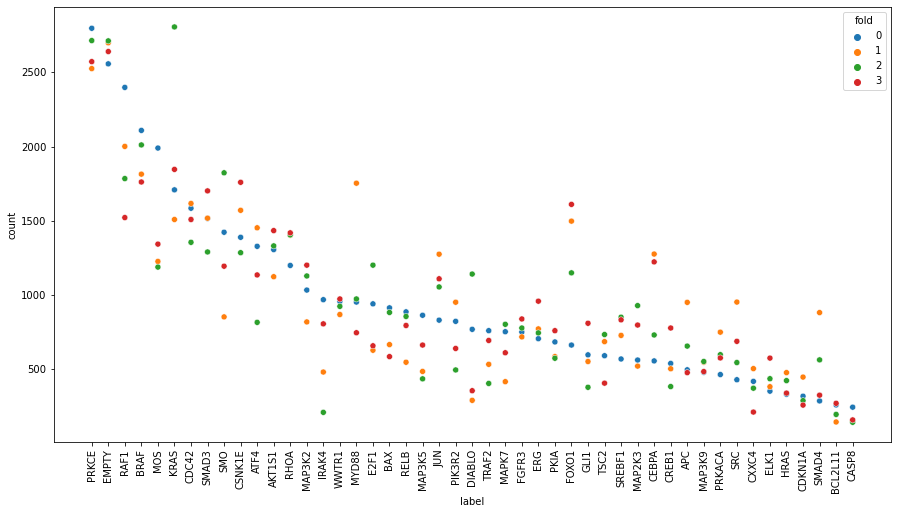

<IPython.core.display.Javascript object>

In [21]:
fig, ax = plt.subplots(figsize=[15, 8])
ax = sns.scatterplot(data=label_counts, x="label", y="count", hue="fold", ax=ax)
plt.xticks(rotation=90)
plt.show()

As mentioned earlier there is quite some variance in the relative distribution of the individual conditions. For instance we have roughly 2700 samples of MAP3K5 as the majority class in fold 2 and just 1600-1800 in the remaining folds. We are working on improving that.

---

## 4. Translational analyses

We will now use the different embeddings of the three different folds in order to model the link between the regulatory and structural space, by given a structural embedding predict the corresponding regulatory embedding. To this end, we will train a linear model for each held-out fold data. To assess the performance, we will evaluate the mapping in three distinct settings:
1. Split the data on a single-nuclei basis, i.e. samples of the same overexpression condition might end up in both the training, validation and test set.
2. Split the data on a OE condition level, i.e. samples of the a certain overexpression condition will be ending up in either of the training, validation and test set.
3. Leave-one-target out cross-validation

We will quickly setup the linear model as well as the corresponding optimizer used for that inference.

In [12]:
model = nn.Sequential(
    nn.Linear(1024, 1024),
    nn.PReLU(),
    nn.BatchNorm1d(1024),
    nn.Linear(1024, 128),
)
optimizer = Adam(model.parameters(), lr=1e-4)
criterion = nn.MSELoss()

<IPython.core.display.Javascript object>

---

### 4.1. Baseline prediction: Nuclei split

We start of with splitting the data into a training, validation and testing set without distinguishing between OE conditions. This will serve as a baseline of how well we can translate between the two spaces within sample.

In [13]:
img_embs_fold0, node_embs_fold0 = img_node_embs_dict["fold0"]

<IPython.core.display.Javascript object>

In [14]:
data_dict = get_data_dict(
    data=img_embs_fold0,
    labels=node_embs_fold0,
    val_test_size=[0.2, 0.2],
    group_labels=None,
    batch_size=128,
)

<IPython.core.display.Javascript object>

In [15]:
fitted_model = train_model(
    model=model,
    data_dict=data_dict,
    optimizer=optimizer,
    criterion=criterion,
    n_epochs=1000,
    early_stopping=20,
)

  0%|          | 1/1000 [00:01<31:10,  1.87s/it]

TRAIN loss: 0.052119517866038294
VAL loss: 0.019470873430328852


  0%|          | 2/1000 [00:03<31:42,  1.91s/it]

TRAIN loss: 0.014443312501841
VAL loss: 0.01078849582668416


  0%|          | 3/1000 [00:05<31:42,  1.91s/it]

TRAIN loss: 0.009172621843919308
VAL loss: 0.007848860575414186


  0%|          | 4/1000 [00:07<31:35,  1.90s/it]

TRAIN loss: 0.007039153284309433
VAL loss: 0.006010003718097894


  0%|          | 5/1000 [00:09<31:32,  1.90s/it]

TRAIN loss: 0.00579849780060718
VAL loss: 0.005126610592006673


  1%|          | 6/1000 [00:11<31:32,  1.90s/it]

TRAIN loss: 0.005020587860376532
VAL loss: 0.0045548914063798076


  1%|          | 7/1000 [00:13<31:29,  1.90s/it]

TRAIN loss: 0.004462940346810281
VAL loss: 0.004107995371500846


  1%|          | 8/1000 [00:15<31:25,  1.90s/it]

TRAIN loss: 0.0040668684187837745
VAL loss: 0.003932225458500432


  1%|          | 9/1000 [00:17<31:19,  1.90s/it]

TRAIN loss: 0.003783945320202225
VAL loss: 0.003615500465160322


  1%|          | 10/1000 [00:18<31:12,  1.89s/it]

TRAIN loss: 0.003534509139432018
VAL loss: 0.0033786456292187023


  1%|          | 11/1000 [00:20<31:14,  1.90s/it]

TRAIN loss: 0.0033320450816335316
VAL loss: 0.0034479050399938566


  1%|          | 12/1000 [00:22<31:13,  1.90s/it]

TRAIN loss: 0.0031971978922504334
VAL loss: 0.0033181081384945003


  1%|▏         | 13/1000 [00:24<31:23,  1.91s/it]

TRAIN loss: 0.003075360824864376
VAL loss: 0.0032292897875102274


  1%|▏         | 14/1000 [00:26<31:51,  1.94s/it]

TRAIN loss: 0.0029417443729596983
VAL loss: 0.0031349451039198602


  2%|▏         | 15/1000 [00:28<31:43,  1.93s/it]

TRAIN loss: 0.0028480204008977717
VAL loss: 0.0029290180377046925


  2%|▏         | 16/1000 [00:30<31:55,  1.95s/it]

TRAIN loss: 0.0027655347845728373
VAL loss: 0.002876249919921534


  2%|▏         | 17/1000 [00:32<32:01,  1.95s/it]

TRAIN loss: 0.00269550349812404
VAL loss: 0.0028585409274849865


  2%|▏         | 18/1000 [00:34<32:14,  1.97s/it]

TRAIN loss: 0.002643467490131768
VAL loss: 0.002851233789429682


  2%|▏         | 19/1000 [00:36<32:25,  1.98s/it]

TRAIN loss: 0.0026190809680754733
VAL loss: 0.0029671371095591286


  2%|▏         | 20/1000 [00:38<32:35,  2.00s/it]

TRAIN loss: 0.002592564838748679
VAL loss: 0.0027548814934482855


  2%|▏         | 21/1000 [00:40<32:11,  1.97s/it]

TRAIN loss: 0.0025100431983458085
VAL loss: 0.0027798442349031686


  2%|▏         | 22/1000 [00:42<31:46,  1.95s/it]

TRAIN loss: 0.002488873024818351
VAL loss: 0.002729275414164229


  2%|▏         | 23/1000 [00:44<31:26,  1.93s/it]

TRAIN loss: 0.0024523450604849936
VAL loss: 0.0026729429465432394


  2%|▏         | 24/1000 [00:46<31:16,  1.92s/it]

TRAIN loss: 0.002410120205345051
VAL loss: 0.0026524694402729394


  2%|▎         | 25/1000 [00:48<31:17,  1.93s/it]

TRAIN loss: 0.002402919352138012
VAL loss: 0.0025369308344294623


  3%|▎         | 26/1000 [00:50<31:11,  1.92s/it]

TRAIN loss: 0.002376840376157006
VAL loss: 0.002719910605491141


  3%|▎         | 27/1000 [00:52<31:15,  1.93s/it]

TRAIN loss: 0.0023404986839328404
VAL loss: 0.0027819222090401793


  3%|▎         | 28/1000 [00:53<31:09,  1.92s/it]

TRAIN loss: 0.002353811048553717
VAL loss: 0.0026757179781984526


  3%|▎         | 29/1000 [00:55<30:59,  1.92s/it]

TRAIN loss: 0.0023297488490967083
VAL loss: 0.0025511771525368924


  3%|▎         | 30/1000 [00:57<30:48,  1.91s/it]

TRAIN loss: 0.002280017453502095
VAL loss: 0.0025480943607803365


  3%|▎         | 31/1000 [00:59<31:27,  1.95s/it]

TRAIN loss: 0.002259527683019862
VAL loss: 0.002613312679668635


  3%|▎         | 32/1000 [01:01<31:12,  1.93s/it]

TRAIN loss: 0.002255144916432709
VAL loss: 0.0026074990833507487


  3%|▎         | 33/1000 [01:03<31:38,  1.96s/it]

TRAIN loss: 0.002227752533207607
VAL loss: 0.002770983081524591


  3%|▎         | 34/1000 [01:05<33:10,  2.06s/it]

TRAIN loss: 0.0022335813915751895
VAL loss: 0.0025113207552559845


  4%|▎         | 35/1000 [01:07<32:36,  2.03s/it]

TRAIN loss: 0.002191087851298907
VAL loss: 0.0025225436132195822


  4%|▎         | 36/1000 [01:09<32:03,  2.00s/it]

TRAIN loss: 0.002196906139227594
VAL loss: 0.0026828249308410595


  4%|▎         | 37/1000 [01:11<31:11,  1.94s/it]

TRAIN loss: 0.0022141647834768934
VAL loss: 0.002584794037783706


  4%|▍         | 38/1000 [01:13<31:23,  1.96s/it]

TRAIN loss: 0.002148264181238532
VAL loss: 0.002827062474410868


  4%|▍         | 39/1000 [01:15<31:42,  1.98s/it]

TRAIN loss: 0.0021662472748511913
VAL loss: 0.0025230153320213032


  4%|▍         | 40/1000 [01:17<31:21,  1.96s/it]

TRAIN loss: 0.0021177952117590795
VAL loss: 0.0026149821159466733


  4%|▍         | 41/1000 [01:19<30:45,  1.92s/it]

TRAIN loss: 0.0021245028832333466
VAL loss: 0.0028000830271511057


  4%|▍         | 42/1000 [01:21<30:38,  1.92s/it]

TRAIN loss: 0.002121474710564338
VAL loss: 0.0023749346003816814


  4%|▍         | 43/1000 [01:23<30:32,  1.92s/it]

TRAIN loss: 0.002092367580940177
VAL loss: 0.0024155226668452403


  4%|▍         | 44/1000 [01:25<30:28,  1.91s/it]

TRAIN loss: 0.002070600740987329
VAL loss: 0.002633469528729569
TRAIN loss: 0.0020626644368927716
VAL loss: 0.002554027336535562


  4%|▍         | 45/1000 [01:27<30:51,  1.94s/it]


TRAIN loss: 0.0020085895017321596
VAL loss: 0.0023749346003816814
TEST loss: 0.0023711997983818563


<IPython.core.display.Javascript object>

In [16]:
ks = [1, 3, 5, 10, 20, 50]
for mode in ["train", "val", "test"]:
    topk_accs = []
    topk_base_accs = []
    preds, labels = get_preds_label_dict(fitted_model, data_dict[mode])
    for k in ks:
        topk_acc, topk_base_acc = evaluate_top_k_accuracy(preds, labels, node_embs, k=k)
        topk_accs.append(topk_acc)
        topk_base_accs.append(topk_base_acc)
    print("{} top-{} accuracies: {}".format(mode.upper(), ks, np.round(topk_accs, 4)))
    print(
        "{} top-{} baseline accuracies: {}".format(
            mode.upper(), ks, np.round(topk_base_accs, 4)
        )
    )
    print(" ")

TRAIN top-[1, 3, 5, 10, 20, 50] accuracies: [0.1755 0.2782 0.3314 0.4206 0.5253 0.7141]
TRAIN top-[1, 3, 5, 10, 20, 50] baseline accuracies: [0.0714 0.1891 0.2728 0.4457 0.6835 1.    ]
 
VAL top-[1, 3, 5, 10, 20, 50] accuracies: [0.1404 0.2228 0.2703 0.355  0.4559 0.6496]
VAL top-[1, 3, 5, 10, 20, 50] baseline accuracies: [0.0761 0.1917 0.277  0.4522 0.6875 1.    ]
 
TEST top-[1, 3, 5, 10, 20, 50] accuracies: [0.138  0.2171 0.2666 0.3473 0.4504 0.6442]
TEST top-[1, 3, 5, 10, 20, 50] baseline accuracies: [0.0717 0.1866 0.2765 0.4583 0.6949 1.    ]
 


<IPython.core.display.Javascript object>

We see that the top-k accuracy suggest indeed a prediction that is better than naive baseline that simply predicts the k-most frequent targets for k<20 for larger k we see that the baseline outperforms the fitted model. The performances of the model on the training, validation and test set are highly comparable.

---

### 4.2. Out-of-sample prediction

In [25]:
data_dict = get_data_dict(
    data=img_embs_fold0,
    labels=node_embs_fold0,
    val_test_size=[0.2, 0.2],
    group_labels=np.array(list(node_embs_fold0.index)),
    batch_size=128,
)

<IPython.core.display.Javascript object>

In [27]:
model = nn.Sequential(
    nn.Linear(1024, 1024),
    nn.PReLU(),
    nn.BatchNorm1d(1024),
    nn.Linear(1024, 128),
)
optimizer = Adam(model.parameters(), lr=1e-4)
criterion = nn.MSELoss()

<IPython.core.display.Javascript object>

In [28]:
fitted_model = train_model(
    model=model,
    data_dict=data_dict,
    optimizer=optimizer,
    criterion=criterion,
    n_epochs=1000,
    early_stopping=20,
)

  0%|          | 1/1000 [00:01<31:42,  1.90s/it]

TRAIN loss: 0.05153900090753767
VAL loss: 0.021213453760211352


  0%|          | 2/1000 [00:03<32:04,  1.93s/it]

TRAIN loss: 0.013752677181743759
VAL loss: 0.011203583337301953


  0%|          | 3/1000 [00:05<32:16,  1.94s/it]

TRAIN loss: 0.008618749280813472
VAL loss: 0.008212178904457015


  0%|          | 4/1000 [00:07<32:31,  1.96s/it]

TRAIN loss: 0.006468091472044348
VAL loss: 0.006859901134741794


  0%|          | 5/1000 [00:09<32:34,  1.96s/it]

TRAIN loss: 0.005283115644277022
VAL loss: 0.006100466759423027


  1%|          | 6/1000 [00:11<32:40,  1.97s/it]

TRAIN loss: 0.004545568982020532
VAL loss: 0.005370264296342597


  1%|          | 7/1000 [00:13<32:29,  1.96s/it]

TRAIN loss: 0.0039564580877420805
VAL loss: 0.004824942794179513
TRAIN loss: 0.0035607276926272282
VAL loss: 0.00466220999030394


  1%|          | 9/1000 [00:17<33:21,  2.02s/it]

TRAIN loss: 0.0032584929512890584
VAL loss: 0.00455332531113653


  1%|          | 10/1000 [00:19<32:58,  2.00s/it]

TRAIN loss: 0.003021478082367695
VAL loss: 0.0042423568341403255


  1%|          | 11/1000 [00:21<32:42,  1.98s/it]

TRAIN loss: 0.0028371454288152755
VAL loss: 0.004093128966820765


  1%|          | 12/1000 [00:23<32:26,  1.97s/it]

TRAIN loss: 0.0026744301072422192
VAL loss: 0.003885721709651935


  1%|▏         | 13/1000 [00:25<32:18,  1.96s/it]

TRAIN loss: 0.002548213412306697
VAL loss: 0.0038977025455277058
TRAIN loss: 0.002460434597961817


  1%|▏         | 14/1000 [00:27<33:02,  2.01s/it]

VAL loss: 0.0038331392738458043


  2%|▏         | 15/1000 [00:29<32:45,  2.00s/it]

TRAIN loss: 0.002367572914729331
VAL loss: 0.0038131926872604785


  2%|▏         | 16/1000 [00:31<32:26,  1.98s/it]

TRAIN loss: 0.0022842762263925293
VAL loss: 0.0036396876197940724
TRAIN loss: 0.00221702444183583


  2%|▏         | 17/1000 [00:33<32:49,  2.00s/it]

VAL loss: 0.003733669389345103


  2%|▏         | 18/1000 [00:35<32:29,  1.99s/it]

TRAIN loss: 0.0021656221931195085
VAL loss: 0.003538104918637674


  2%|▏         | 19/1000 [00:37<32:18,  1.98s/it]

TRAIN loss: 0.002115107133489112
VAL loss: 0.00363555522947174


  2%|▏         | 20/1000 [00:39<32:34,  1.99s/it]

TRAIN loss: 0.0020698788835799456
VAL loss: 0.003625390221638307


  2%|▏         | 21/1000 [00:41<32:40,  2.00s/it]

TRAIN loss: 0.0020487384309043166
VAL loss: 0.0036469649918183518


  2%|▏         | 22/1000 [00:43<32:30,  1.99s/it]

TRAIN loss: 0.001995780275071143
VAL loss: 0.003608580728585438


  2%|▏         | 23/1000 [00:45<32:52,  2.02s/it]

TRAIN loss: 0.001964980658156693
VAL loss: 0.0036087838914406934
TRAIN loss: 0.0019334026456141688


  2%|▏         | 24/1000 [00:47<33:09,  2.04s/it]

VAL loss: 0.0035023760427045723


  2%|▎         | 25/1000 [00:49<33:19,  2.05s/it]

TRAIN loss: 0.001920290433973211
VAL loss: 0.0035276314373216978


  3%|▎         | 26/1000 [00:51<33:15,  2.05s/it]

TRAIN loss: 0.0018990153250153846
VAL loss: 0.0035104972874697256


  3%|▎         | 27/1000 [00:53<32:59,  2.03s/it]

TRAIN loss: 0.0018576078255988808
VAL loss: 0.0035470576537801864


  3%|▎         | 28/1000 [00:55<32:20,  2.00s/it]

TRAIN loss: 0.0018526195647474888
VAL loss: 0.003598537348681666
TRAIN loss: 0.0018495904546064303


  3%|▎         | 29/1000 [00:57<32:12,  1.99s/it]

VAL loss: 0.0035630710603313837


  3%|▎         | 30/1000 [00:59<32:30,  2.01s/it]

TRAIN loss: 0.0018059704222160326
VAL loss: 0.0034173011642741097


  3%|▎         | 31/1000 [01:01<32:35,  2.02s/it]

TRAIN loss: 0.0017852244459515513
VAL loss: 0.0032941027487745876
TRAIN loss: 0.001788279420543627


  3%|▎         | 32/1000 [01:04<33:02,  2.05s/it]

VAL loss: 0.0032978170406237207


  3%|▎         | 33/1000 [01:05<32:05,  1.99s/it]

TRAIN loss: 0.0017485892502359533
VAL loss: 0.003371961660036307
TRAIN loss: 0.0017387729931398598


  3%|▎         | 34/1000 [01:07<32:37,  2.03s/it]

VAL loss: 0.0033685290111838163


  4%|▎         | 35/1000 [01:10<33:01,  2.05s/it]

TRAIN loss: 0.0017305061621786255
VAL loss: 0.003422048422011698


  4%|▎         | 36/1000 [01:12<32:53,  2.05s/it]

TRAIN loss: 0.0017023758599746788
VAL loss: 0.0034819537107549986
TRAIN loss: 0.001705525503036209


  4%|▎         | 37/1000 [01:14<33:10,  2.07s/it]

VAL loss: 0.0032970075641817597


  4%|▍         | 38/1000 [01:16<32:36,  2.03s/it]

TRAIN loss: 0.0016888415574165903
VAL loss: 0.003402272814926905


  4%|▍         | 39/1000 [01:17<31:21,  1.96s/it]

TRAIN loss: 0.0016959114666692129
VAL loss: 0.0035797798255680054


  4%|▍         | 40/1000 [01:20<32:00,  2.00s/it]

TRAIN loss: 0.0016592237571489874
VAL loss: 0.003420898009869449


TRAIN loss: 0.001678404423776567
VAL loss: 0.0032941027487745876
TEST loss: 0.004975452041843656


<IPython.core.display.Javascript object>

In [30]:
ks = [1, 3, 5, 10, 20, 50]
for mode in ["train", "val", "test"]:
    topk_accs = []
    topk_base_accs = []
    preds, labels = get_preds_label_dict(fitted_model, data_dict[mode])
    for k in ks:
        topk_acc, topk_base_acc = evaluate_top_k_accuracy(preds, labels, node_embs, k=k)
        topk_accs.append(topk_acc)
        topk_base_accs.append(topk_base_acc)
    print("{} top-{} accuracies: {}".format(mode.upper(), ks, np.round(topk_accs, 4)))
    #     print(
    #         "{} top-{} baseline accuracies: {}".format(
    #             mode.upper(), ks, np.round(topk_base_accs, 4)
    #         )
    #     )
    print(" ")

TRAIN top-[1, 3, 5, 10, 20, 50] accuracies: [0.2057 0.3159 0.3755 0.4716 0.5822 0.7633]
 
VAL top-[1, 3, 5, 10, 20, 50] accuracies: [0.1186 0.2009 0.2502 0.331  0.4218 0.5646]
 
TEST top-[1, 3, 5, 10, 20, 50] accuracies: [0.0998 0.155  0.1871 0.2487 0.3213 0.4465]
 


<IPython.core.display.Javascript object>

Note that for the held-out configuration the baseline accuracies are not reliable as those correspond to the most frequent classes in the corresponding data set.

---

### 4.3. Leave-one-out cross-validation

Finally, we will apply leave-one-target out crossvalidation.

In [48]:
def get_logo_data_dicts(
    data,
    labels,
    group_labels,
    val_size=0.1,
    batch_size=128,
    random_state=1234,
    scale_x=True,
    scale_y=False,
):
    logo = LeaveOneGroupOut()
    data_dicts = []
    idc = list(range(len(labels)))
    for train_val_idc, test_idc in logo.split(idc, groups=group_labels):
        gss = gss = GroupShuffleSplit(
            n_splits=2, test_size=val_size, random_state=random_state
        )
        train_idc, val_idc = next(
            gss.split(train_val_idc, groups=group_labels[train_val_idc])
        )

        train_data, train_labels = data.iloc[train_idc], labels.iloc[train_idc]
        val_data, val_labels = data.iloc[val_idc], labels.iloc[val_idc]
        test_data, test_labels = data.iloc[test_idc], labels.iloc[test_idc]

        if scale_x:
            sc = StandardScaler().fit(train_data)
            train_data = sc.transform(train_data)
            val_data = sc.transform(val_data)
            test_data = sc.transform(test_data)

        if scale_y:
            sc = StandardScaler().fit(train_labels)
            train_labels = sc.transform(train_labels)
            val_labels = sc.transform(val_labels)
            test_labels = sc.transform(test_labels)

        train_dataset = IndexedTensorDataset(
            torch.FloatTensor(np.array(train_data)),
            torch.FloatTensor(np.array(train_labels)),
            list(labels.iloc[train_idc].index),
        )
        train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)

        val_dataset = IndexedTensorDataset(
            torch.FloatTensor(np.array(val_data)),
            torch.FloatTensor(np.array(val_labels)),
            list(labels.iloc[val_idc].index),
        )
        val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False)

        test_dataset = IndexedTensorDataset(
            torch.FloatTensor(np.array(test_data)),
            torch.FloatTensor(np.array(test_labels)),
            list(labels.iloc[test_idc].index),
        )
        test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

        data_dict = {"train": train_loader, "val": val_loader, "test": test_loader}
        data_dicts.append(data_dict)
    return data_dicts

<IPython.core.display.Javascript object>

In [49]:
data_dicts = get_logo_data_dicts(
    data=img_embs_fold0,
    labels=node_embs_fold0,
    val_size=0.1,
    group_labels=np.array(list(node_embs_fold0.index)),
    batch_size=128,
)

<IPython.core.display.Javascript object>

In [59]:
topk_test_accs = []
lo_labels = []
for i in tqdm(range(len(data_dicts))):
    data_dict = data_dicts[i]

    model = nn.Sequential(
        nn.Linear(1024, 1024),
        nn.PReLU(),
        nn.BatchNorm1d(1024),
        nn.Linear(1024, 128),
    )
    optimizer = Adam(model.parameters(), lr=1e-4)
    criterion = nn.MSELoss()

    fitted_model = train_model(
        model=model,
        data_dict=data_dict,
        optimizer=optimizer,
        criterion=criterion,
        n_epochs=100,
        early_stopping=5,
    )

    ks = [1, 3, 5, 10, 20, 50]
    for mode in ["train", "val", "test"]:
        topk_accs = []
        preds, labels = get_preds_label_dict(fitted_model, data_dict[mode])
        if mode == "test":
            lo_label = np.unique(labels)[0]
            lo_labels.append(lo_label)
            print("Left-out label: {}".format(lo_label))
        for k in ks:
            topk_acc, _ = evaluate_top_k_accuracy(preds, labels, node_embs, k=k)
            topk_accs.append(topk_acc)
        print(
            "{} top-{} accuracies: {}".format(mode.upper(), ks, np.round(topk_accs, 4))
        )
        print("---")
    topk_test_accs.append(np.array(topk_accs))

  0%|          | 0/43 [00:00<?, ?it/s]

TRAIN loss: 0.002368250949839358
VAL loss: 0.0037462071118761165
TEST loss: 0.000957269584349717
TRAIN top-[1, 3, 5, 10, 20, 50] accuracies: [0.145  0.238  0.2902 0.3767 0.4814 0.6707]
 
VAL top-[1, 3, 5, 10, 20, 50] accuracies: [0.044  0.0742 0.0941 0.1289 0.182  0.3807]
 
Left-out label: AKT1S1


  2%|▏         | 1/43 [00:58<40:48, 58.29s/it]

TEST top-[1, 3, 5, 10, 20, 50] accuracies: [0.3441 0.6314 0.79   0.9326 0.9839 1.    ]
 
TRAIN loss: 0.0022714127204746123
VAL loss: 0.0065110403086239875
TEST loss: 0.00624244865821863
TRAIN top-[1, 3, 5, 10, 20, 50] accuracies: [0.1325 0.2203 0.275  0.3626 0.4686 0.6654]
 


  5%|▍         | 2/43 [01:48<36:45, 53.80s/it]

VAL top-[1, 3, 5, 10, 20, 50] accuracies: [0.0298 0.0613 0.0777 0.1108 0.1438 0.2627]
 
Left-out label: APC
TEST top-[1, 3, 5, 10, 20, 50] accuracies: [0.     0.     0.002  0.0061 0.0243 0.0526]
 
TRAIN loss: 0.0022424969523594327
VAL loss: 0.0035594913195346875
TEST loss: 0.0014246443801327203
TRAIN top-[1, 3, 5, 10, 20, 50] accuracies: [0.1614 0.2506 0.299  0.3862 0.4862 0.6735]
 
VAL top-[1, 3, 5, 10, 20, 50] accuracies: [0.0601 0.1006 0.1316 0.1706 0.2309 0.3931]
 
Left-out label: ATF4


  7%|▋         | 3/43 [02:53<39:13, 58.84s/it]

TEST top-[1, 3, 5, 10, 20, 50] accuracies: [0.2977 0.3527 0.3949 0.4921 0.6157 0.8448]
 
TRAIN loss: 0.002303326461378584
VAL loss: 0.002965224821521522
TEST loss: 0.0017138289455161022
TRAIN top-[1, 3, 5, 10, 20, 50] accuracies: [0.1504 0.2403 0.2897 0.3754 0.4786 0.6628]
 
VAL top-[1, 3, 5, 10, 20, 50] accuracies: [0.0623 0.1227 0.1547 0.2158 0.2873 0.4952]
 
Left-out label: BAX


  9%|▉         | 4/43 [03:47<36:57, 56.86s/it]

TEST top-[1, 3, 5, 10, 20, 50] accuracies: [0.1919 0.2346 0.2544 0.3026 0.3871 0.6623]
 
TRAIN loss: 0.0020505842486042733
VAL loss: 0.006610062697380578
TEST loss: 0.002075924311586971
TRAIN top-[1, 3, 5, 10, 20, 50] accuracies: [0.1571 0.253  0.307  0.3973 0.5043 0.6939]
 


 12%|█▏        | 5/43 [05:05<40:54, 64.58s/it]

VAL top-[1, 3, 5, 10, 20, 50] accuracies: [0.0181 0.0345 0.0454 0.069  0.0983 0.1944]
 
Left-out label: BCL2L11
TEST top-[1, 3, 5, 10, 20, 50] accuracies: [0.0545 0.0778 0.1012 0.1323 0.1946 0.4319]
 
TRAIN loss: 0.00266708830120884
VAL loss: 0.002995565734264356
TEST loss: 0.0021782946251129626
TRAIN top-[1, 3, 5, 10, 20, 50] accuracies: [0.1296 0.2169 0.2667 0.3457 0.4505 0.6425]
 
VAL top-[1, 3, 5, 10, 20, 50] accuracies: [0.0422 0.0805 0.1008 0.1547 0.2376 0.4443]
 
Left-out label: BRAF


 14%|█▍        | 6/43 [06:34<44:47, 72.62s/it]

TEST top-[1, 3, 5, 10, 20, 50] accuracies: [0.1792 0.2361 0.2693 0.331  0.4358 0.6349]
 
TRAIN loss: 0.0022335568099627148
VAL loss: 0.006148018528942527
TEST loss: 0.002114036882465536
TRAIN top-[1, 3, 5, 10, 20, 50] accuracies: [0.1495 0.2451 0.3008 0.3853 0.49   0.677 ]
 


 16%|█▋        | 7/43 [07:19<38:18, 63.85s/it]

VAL top-[1, 3, 5, 10, 20, 50] accuracies: [0.0209 0.0422 0.0643 0.0959 0.1338 0.2463]
 
Left-out label: CASP8
TEST top-[1, 3, 5, 10, 20, 50] accuracies: [0.0372 0.0413 0.062  0.0909 0.157  0.5041]
 
TRAIN loss: 0.0021689702655543312
VAL loss: 0.0047562784410787404
TEST loss: 0.0016327697508545084
TRAIN top-[1, 3, 5, 10, 20, 50] accuracies: [0.1488 0.2448 0.2968 0.3815 0.4834 0.6687]
 
VAL top-[1, 3, 5, 10, 20, 50] accuracies: [0.0427 0.0815 0.0988 0.1294 0.1731 0.3042]
 
Left-out label: CDC42


 19%|█▊        | 8/43 [08:17<35:59, 61.71s/it]

TEST top-[1, 3, 5, 10, 20, 50] accuracies: [0.1313 0.2279 0.2784 0.3504 0.4741 0.774 ]
 
TRAIN loss: 0.002030169908471231
VAL loss: 0.007004758082459738
TEST loss: 0.026828353517229044
TRAIN top-[1, 3, 5, 10, 20, 50] accuracies: [0.1602 0.2584 0.3094 0.3931 0.4971 0.6871]
 


 21%|██        | 9/43 [09:05<32:42, 57.71s/it]

VAL top-[1, 3, 5, 10, 20, 50] accuracies: [0.0219 0.0412 0.0517 0.0718 0.105  0.2106]
 
Left-out label: CDKN1A
TEST top-[1, 3, 5, 10, 20, 50] accuracies: [0. 0. 0. 0. 0. 0.]
 
TRAIN loss: 0.0020948097875683643
VAL loss: 0.006235390031446282
TEST loss: 0.0019406014944120756
TRAIN top-[1, 3, 5, 10, 20, 50] accuracies: [0.1705 0.2654 0.3197 0.4072 0.5081 0.6815]
 


 23%|██▎       | 10/43 [09:58<30:47, 56.00s/it]

VAL top-[1, 3, 5, 10, 20, 50] accuracies: [0.0066 0.0145 0.0211 0.0438 0.0855 0.1763]
 
Left-out label: CEBPA
TEST top-[1, 3, 5, 10, 20, 50] accuracies: [0.0253 0.1227 0.2401 0.37   0.5162 0.731 ]
 
TRAIN loss: 0.002025749936609515
VAL loss: 0.006582453683784095
TEST loss: 0.0026616432237503026
TRAIN top-[1, 3, 5, 10, 20, 50] accuracies: [0.1716 0.2672 0.3218 0.4125 0.5179 0.7037]
 


 26%|██▌       | 11/43 [10:51<29:30, 55.32s/it]

VAL top-[1, 3, 5, 10, 20, 50] accuracies: [0.0179 0.0256 0.034  0.0509 0.0823 0.1771]
 
Left-out label: CREB1
TEST top-[1, 3, 5, 10, 20, 50] accuracies: [0.     0.     0.     0.     0.0019 0.0801]
 
TRAIN loss: 0.0021130588377388055
VAL loss: 0.005886470300128961
TEST loss: 0.0031181789996561435
TRAIN top-[1, 3, 5, 10, 20, 50] accuracies: [0.156  0.2546 0.3064 0.3939 0.4946 0.6749]
 


 28%|██▊       | 12/43 [11:49<28:52, 55.89s/it]

VAL top-[1, 3, 5, 10, 20, 50] accuracies: [0.018  0.0351 0.0469 0.0778 0.1183 0.2908]
 
Left-out label: DIABLO
TEST top-[1, 3, 5, 10, 20, 50] accuracies: [0.     0.0013 0.0091 0.0326 0.0717 0.2334]
 
TRAIN loss: 0.002096760941855544
VAL loss: 0.00522824192166341
TEST loss: 0.004444232547241119
TRAIN top-[1, 3, 5, 10, 20, 50] accuracies: [0.1566 0.2534 0.3059 0.3917 0.4925 0.675 ]
 
VAL top-[1, 3, 5, 10, 20, 50] accuracies: [0.032  0.0613 0.079  0.1135 0.1602 0.3307]
 
Left-out label: E2F1


 30%|███       | 13/43 [12:51<28:53, 57.77s/it]

TEST top-[1, 3, 5, 10, 20, 50] accuracies: [0.0256 0.0788 0.1044 0.1491 0.196  0.3003]
 
TRAIN loss: 0.002178936307762564
VAL loss: 0.007441637306033217
TEST loss: 0.001154966336408896
TRAIN top-[1, 3, 5, 10, 20, 50] accuracies: [0.168  0.2649 0.3165 0.4001 0.496  0.6811]
 


 33%|███▎      | 14/43 [13:42<26:58, 55.82s/it]

VAL top-[1, 3, 5, 10, 20, 50] accuracies: [0.0087 0.0169 0.0225 0.0346 0.0596 0.193 ]
 
Left-out label: ELK1
TEST top-[1, 3, 5, 10, 20, 50] accuracies: [0.1257 0.3943 0.5286 0.74   0.8657 1.    ]
 
TRAIN loss: 0.0021968899152679327
VAL loss: 0.005986038621998622
TEST loss: 0.003185962707820264
TRAIN top-[1, 3, 5, 10, 20, 50] accuracies: [0.1361 0.2179 0.2678 0.3528 0.4612 0.6552]
 
VAL top-[1, 3, 5, 10, 20, 50] accuracies: [0.0289 0.0615 0.0837 0.1304 0.1779 0.3158]
 
Left-out label: ERG


 35%|███▍      | 15/43 [14:36<25:48, 55.29s/it]

TEST top-[1, 3, 5, 10, 20, 50] accuracies: [0.1378 0.1619 0.1761 0.2088 0.2415 0.3523]
 
TRAIN loss: 0.002218105375376989
VAL loss: 0.006112366589479699
TEST loss: 0.0032352609376488962
TRAIN top-[1, 3, 5, 10, 20, 50] accuracies: [0.1599 0.2615 0.3148 0.3997 0.4847 0.6587]
 
VAL top-[1, 3, 5, 10, 20, 50] accuracies: [0.0155 0.0326 0.0452 0.0806 0.1278 0.2706]
 
Left-out label: FGFR3


 37%|███▋      | 16/43 [15:30<24:44, 54.97s/it]

TEST top-[1, 3, 5, 10, 20, 50] accuracies: [0.     0.0013 0.0013 0.0053 0.0134 0.1268]
 
TRAIN loss: 0.00239616823329898
VAL loss: 0.006518207698742236
TEST loss: 0.001248290262124452
TRAIN top-[1, 3, 5, 10, 20, 50] accuracies: [0.1427 0.2309 0.2849 0.3711 0.477  0.6636]
 


 40%|███▉      | 17/43 [16:11<21:57, 50.66s/it]

VAL top-[1, 3, 5, 10, 20, 50] accuracies: [0.0135 0.0312 0.0413 0.0708 0.1099 0.2374]
 
Left-out label: FOXO1
TEST top-[1, 3, 5, 10, 20, 50] accuracies: [0.1634 0.348  0.4493 0.6309 0.8139 0.9955]
 
TRAIN loss: 0.0021673696963193244
VAL loss: 0.006216927201048285
TEST loss: 0.006354116168687073
TRAIN top-[1, 3, 5, 10, 20, 50] accuracies: [0.1512 0.2498 0.3011 0.3882 0.4883 0.673 ]
 


 42%|████▏     | 18/43 [17:07<21:48, 52.34s/it]

VAL top-[1, 3, 5, 10, 20, 50] accuracies: [0.018  0.0419 0.0621 0.0958 0.1366 0.261 ]
 
Left-out label: GLI1
TEST top-[1, 3, 5, 10, 20, 50] accuracies: [0.     0.     0.     0.0017 0.005  0.0269]
 
TRAIN loss: 0.001965650145491979
VAL loss: 0.007497003576566094
TEST loss: 0.0011289394775541404
TRAIN top-[1, 3, 5, 10, 20, 50] accuracies: [0.1652 0.261  0.3162 0.4139 0.5238 0.7066]
 


 44%|████▍     | 19/43 [19:17<30:15, 75.64s/it]

VAL top-[1, 3, 5, 10, 20, 50] accuracies: [0.0154 0.0282 0.0382 0.0565 0.0698 0.1584]
 
Left-out label: HRAS
TEST top-[1, 3, 5, 10, 20, 50] accuracies: [0.3252 0.4468 0.5471 0.7416 0.8997 0.9818]
 
TRAIN loss: 0.0020373394845796785
VAL loss: 0.005897947834025508
TEST loss: 0.002572566975098808
TRAIN top-[1, 3, 5, 10, 20, 50] accuracies: [0.156  0.2583 0.315  0.4065 0.5127 0.695 ]
 
VAL top-[1, 3, 5, 10, 20, 50] accuracies: [0.0191 0.0335 0.0444 0.0675 0.0944 0.2552]
 
Left-out label: IRAK4


 47%|████▋     | 20/43 [20:16<27:06, 70.71s/it]

TEST top-[1, 3, 5, 10, 20, 50] accuracies: [0.0517 0.1013 0.121  0.1675 0.2192 0.4012]
 
TRAIN loss: 0.0018714750547436565
VAL loss: 0.006218116445576443
TEST loss: 0.0010060800424247836
TRAIN top-[1, 3, 5, 10, 20, 50] accuracies: [0.1824 0.2848 0.3407 0.4279 0.5297 0.7124]
 
VAL top-[1, 3, 5, 10, 20, 50] accuracies: [0.035  0.0515 0.0607 0.0805 0.1108 0.2455]
 
Left-out label: JUN


 49%|████▉     | 21/43 [21:24<25:34, 69.76s/it]

TEST top-[1, 3, 5, 10, 20, 50] accuracies: [0.4729 0.6273 0.7069 0.8106 0.8745 0.9614]
 
TRAIN loss: 0.0021544176064468585
VAL loss: 0.005993506940191283
TEST loss: 0.0011514213788966525
TRAIN top-[1, 3, 5, 10, 20, 50] accuracies: [0.1613 0.2566 0.311  0.4009 0.5034 0.6876]
 
VAL top-[1, 3, 5, 10, 20, 50] accuracies: [0.0052 0.0136 0.0204 0.0353 0.0617 0.1814]
 
Left-out label: KRAS


 51%|█████     | 22/43 [22:15<22:30, 64.30s/it]

TEST top-[1, 3, 5, 10, 20, 50] accuracies: [0.1797 0.3466 0.4532 0.6417 0.815  0.9854]
 
TRAIN loss: 0.0022501410299373345
VAL loss: 0.007078139330412633
TEST loss: 0.0013943629306075829
TRAIN top-[1, 3, 5, 10, 20, 50] accuracies: [0.1464 0.2396 0.2935 0.3799 0.4884 0.6747]
 


 53%|█████▎    | 23/43 [23:00<19:24, 58.25s/it]

VAL top-[1, 3, 5, 10, 20, 50] accuracies: [0.0157 0.0361 0.0497 0.0795 0.1103 0.2073]
 
Left-out label: MAP2K3
TEST top-[1, 3, 5, 10, 20, 50] accuracies: [0.0821 0.2089 0.3286 0.55   0.8232 0.9982]
 
TRAIN loss: 0.002091574103753779
VAL loss: 0.005903125894834208
TEST loss: 0.0011637187544834013
TRAIN top-[1, 3, 5, 10, 20, 50] accuracies: [0.1754 0.2685 0.3222 0.4115 0.5181 0.7006]
 
VAL top-[1, 3, 5, 10, 20, 50] accuracies: [0.0285 0.0437 0.0515 0.0661 0.0907 0.2259]
 
Left-out label: MAP3K2


 56%|█████▌    | 24/43 [23:51<17:47, 56.17s/it]

TEST top-[1, 3, 5, 10, 20, 50] accuracies: [0.2151 0.3634 0.4767 0.6773 0.8556 0.9797]
 
TRAIN loss: 0.0021201160563482464
VAL loss: 0.006316393232399148
TEST loss: 0.0008580055592361224
TRAIN top-[1, 3, 5, 10, 20, 50] accuracies: [0.1713 0.2702 0.3247 0.412  0.5121 0.6905]
 
VAL top-[1, 3, 5, 10, 20, 50] accuracies: [0.017  0.0275 0.0337 0.0507 0.0797 0.2005]
 
Left-out label: MAP3K5


 58%|█████▊    | 25/43 [24:43<16:29, 54.95s/it]

TEST top-[1, 3, 5, 10, 20, 50] accuracies: [0.4768 0.7773 0.8585 0.9281 0.978  1.    ]
 
TRAIN loss: 0.0021665986137696007
VAL loss: 0.00705298631129409
TEST loss: 0.0031026557363194865
TRAIN top-[1, 3, 5, 10, 20, 50] accuracies: [0.1394 0.2355 0.2882 0.3769 0.4889 0.6759]
 


 60%|██████    | 26/43 [25:34<15:14, 53.78s/it]

VAL top-[1, 3, 5, 10, 20, 50] accuracies: [0.0165 0.0322 0.0424 0.063  0.0863 0.1995]
 
Left-out label: MAP3K9
TEST top-[1, 3, 5, 10, 20, 50] accuracies: [0.1384 0.1593 0.1782 0.2034 0.2558 0.3585]
 
TRAIN loss: 0.0025391433892955713
VAL loss: 0.006869516853924865
TEST loss: 0.0022875573104755896
TRAIN top-[1, 3, 5, 10, 20, 50] accuracies: [0.1213 0.2096 0.2621 0.3494 0.4619 0.6572]
 
VAL top-[1, 3, 5, 10, 20, 50] accuracies: [0.0285 0.0486 0.0682 0.0999 0.1367 0.2648]
 
Left-out label: MAPK7


 63%|██████▎   | 27/43 [26:21<13:45, 51.61s/it]

TEST top-[1, 3, 5, 10, 20, 50] accuracies: [0.1518 0.2197 0.257  0.3196 0.4008 0.6165]
 
TRAIN loss: 0.0022066643714209115
VAL loss: 0.006021125559128967
TEST loss: 0.0027933003873976594
TRAIN top-[1, 3, 5, 10, 20, 50] accuracies: [0.1581 0.2559 0.3107 0.3968 0.4971 0.6789]
 
VAL top-[1, 3, 5, 10, 20, 50] accuracies: [0.0118 0.0361 0.0531 0.0763 0.1085 0.2944]
 
Left-out label: MYD88


 65%|██████▌   | 28/43 [27:14<13:00, 52.05s/it]

TEST top-[1, 3, 5, 10, 20, 50] accuracies: [0.0042 0.0315 0.0389 0.0557 0.082  0.2324]
 
TRAIN loss: 0.0020590157413823626
VAL loss: 0.006115636882901776
TEST loss: 0.0010373032515432945
TRAIN top-[1, 3, 5, 10, 20, 50] accuracies: [0.1665 0.2623 0.3158 0.4028 0.5002 0.6843]
 


 67%|██████▋   | 29/43 [28:09<12:21, 52.98s/it]

VAL top-[1, 3, 5, 10, 20, 50] accuracies: [0.0136 0.0314 0.041  0.0724 0.108  0.2586]
 
Left-out label: PIK3R2
TEST top-[1, 3, 5, 10, 20, 50] accuracies: [0.095  0.324  0.4592 0.6565 0.866  0.9963]
 
TRAIN loss: 0.002120280717098209
VAL loss: 0.006422980585579876
TEST loss: 0.0055795720849415595
TRAIN top-[1, 3, 5, 10, 20, 50] accuracies: [0.148  0.2441 0.3014 0.3957 0.499  0.6829]
 
VAL top-[1, 3, 5, 10, 20, 50] accuracies: [0.0102 0.0301 0.0421 0.0719 0.1082 0.2196]
 
Left-out label: PKIA


 70%|██████▉   | 30/43 [29:02<11:30, 53.14s/it]

TEST top-[1, 3, 5, 10, 20, 50] accuracies: [0.0044 0.022  0.0293 0.0411 0.0528 0.1056]
 
TRAIN loss: 0.002078411934410639
VAL loss: 0.007284882962460222
TEST loss: 0.0041701565577257505
TRAIN top-[1, 3, 5, 10, 20, 50] accuracies: [0.1624 0.2598 0.314  0.3998 0.5062 0.6988]
 


 72%|███████▏  | 31/43 [29:51<10:22, 51.84s/it]

VAL top-[1, 3, 5, 10, 20, 50] accuracies: [0.0144 0.022  0.029  0.0458 0.0703 0.149 ]
 
Left-out label: PRKACA
TEST top-[1, 3, 5, 10, 20, 50] accuracies: [0.0281 0.0368 0.0433 0.0498 0.0736 0.1385]
 
TRAIN loss: 0.002499027049640789
VAL loss: 0.006546900758544117
TEST loss: 0.0014371315514624886
TRAIN top-[1, 3, 5, 10, 20, 50] accuracies: [0.126  0.2191 0.2761 0.3714 0.4867 0.6722]
 
VAL top-[1, 3, 5, 10, 20, 50] accuracies: [0.0058 0.0089 0.0146 0.0298 0.0575 0.2073]
 
Left-out label: PRKCE


 74%|███████▍  | 32/43 [30:59<10:24, 56.78s/it]

TEST top-[1, 3, 5, 10, 20, 50] accuracies: [0.2505 0.4067 0.4936 0.644  0.7959 0.9353]
 
TRAIN loss: 0.0022253988835673694
VAL loss: 0.005820272203193966
TEST loss: 0.0019971237622419618
TRAIN top-[1, 3, 5, 10, 20, 50] accuracies: [0.1632 0.2645 0.3215 0.4127 0.5123 0.6896]
 
VAL top-[1, 3, 5, 10, 20, 50] accuracies: [0.0178 0.0421 0.0557 0.0831 0.1252 0.2635]
 
Left-out label: RAF1


 77%|███████▋  | 33/43 [32:38<11:33, 69.34s/it]

TEST top-[1, 3, 5, 10, 20, 50] accuracies: [0.351  0.4356 0.4673 0.534  0.5994 0.727 ]
 
TRAIN loss: 0.002030366470703398
VAL loss: 0.006049351759583634
TEST loss: 0.001161336534298788
TRAIN top-[1, 3, 5, 10, 20, 50] accuracies: [0.1819 0.2787 0.3323 0.422  0.5213 0.6953]
 
VAL top-[1, 3, 5, 10, 20, 50] accuracies: [0.0217 0.0358 0.0471 0.0682 0.1085 0.2371]
 
Left-out label: RELB


 79%|███████▉  | 34/43 [33:34<09:48, 65.42s/it]

TEST top-[1, 3, 5, 10, 20, 50] accuracies: [0.2802 0.4102 0.4893 0.6215 0.7819 0.9627]
 
TRAIN loss: 0.002223716611064511
VAL loss: 0.005787580035279925
TEST loss: 0.001603180453576185
TRAIN top-[1, 3, 5, 10, 20, 50] accuracies: [0.1629 0.2628 0.3168 0.4049 0.504  0.6755]
 
VAL top-[1, 3, 5, 10, 20, 50] accuracies: [0.0089 0.0254 0.0387 0.0612 0.0824 0.2013]
 
Left-out label: RHOA


 81%|████████▏ | 35/43 [34:26<08:09, 61.18s/it]

TEST top-[1, 3, 5, 10, 20, 50] accuracies: [0.0568 0.1469 0.2037 0.3606 0.525  0.7972]
 
TRAIN loss: 0.002550007228801946
VAL loss: 0.006003473279754224
TEST loss: 0.005128615632616352
TRAIN top-[1, 3, 5, 10, 20, 50] accuracies: [0.1479 0.2326 0.2836 0.3707 0.479  0.6598]
 
VAL top-[1, 3, 5, 10, 20, 50] accuracies: [0.0133 0.0196 0.0243 0.0335 0.0489 0.1684]
 
Left-out label: SMAD3


 84%|████████▎ | 36/43 [35:17<06:47, 58.24s/it]

TEST top-[1, 3, 5, 10, 20, 50] accuracies: [0.0007 0.0013 0.004  0.0099 0.031  0.0746]
 
TRAIN loss: 0.0020280320131368062
VAL loss: 0.0076237019645719745
TEST loss: 0.0025911398796023615
TRAIN top-[1, 3, 5, 10, 20, 50] accuracies: [0.1559 0.2428 0.2994 0.3961 0.5057 0.6889]
 


 86%|████████▌ | 37/43 [36:06<05:33, 55.55s/it]

VAL top-[1, 3, 5, 10, 20, 50] accuracies: [0.0115 0.0238 0.0298 0.0416 0.0539 0.1218]
 
Left-out label: SMAD4
TEST top-[1, 3, 5, 10, 20, 50] accuracies: [0.     0.0035 0.007  0.0141 0.0211 0.3662]
 
TRAIN loss: 0.0022733868579425673
VAL loss: 0.006668712142749215
TEST loss: 0.006591470408451163
TRAIN top-[1, 3, 5, 10, 20, 50] accuracies: [0.1568 0.2495 0.3001 0.3866 0.4902 0.6632]
 
VAL top-[1, 3, 5, 10, 20, 50] accuracies: [0.0082 0.0156 0.0216 0.0335 0.0484 0.1652]
 
Left-out label: SMO


 88%|████████▊ | 38/43 [36:53<04:24, 52.88s/it]

TEST top-[1, 3, 5, 10, 20, 50] accuracies: [0.0323 0.0612 0.0682 0.0802 0.0963 0.1449]
 
TRAIN loss: 0.0023260426111578075
VAL loss: 0.006362923861758185
TEST loss: 0.003928550860388706
TRAIN top-[1, 3, 5, 10, 20, 50] accuracies: [0.1336 0.2209 0.272  0.3594 0.4699 0.6531]
 


 91%|█████████ | 39/43 [37:42<03:26, 51.71s/it]

VAL top-[1, 3, 5, 10, 20, 50] accuracies: [0.0298 0.0573 0.0681 0.0912 0.1243 0.2252]
 
Left-out label: SRC
TEST top-[1, 3, 5, 10, 20, 50] accuracies: [0.     0.0023 0.0047 0.0094 0.0211 0.1358]
 
TRAIN loss: 0.0021027185024726463
VAL loss: 0.006512746897154874
TEST loss: 0.0012131446050200776
TRAIN top-[1, 3, 5, 10, 20, 50] accuracies: [0.1595 0.2559 0.3064 0.3927 0.4982 0.689 ]
 


 93%|█████████▎| 40/43 [38:38<02:38, 52.97s/it]

VAL top-[1, 3, 5, 10, 20, 50] accuracies: [0.0041 0.0141 0.0231 0.0428 0.0808 0.2118]
 
Left-out label: SREBF1
TEST top-[1, 3, 5, 10, 20, 50] accuracies: [0.2099 0.3492 0.425  0.5256 0.7002 0.9383]
 
TRAIN loss: 0.0021319000809432915
VAL loss: 0.006365781953051592
TEST loss: 0.0019318628239157881
TRAIN top-[1, 3, 5, 10, 20, 50] accuracies: [0.1574 0.246  0.2965 0.3816 0.4841 0.6715]
 
VAL top-[1, 3, 5, 10, 20, 50] accuracies: [0.013  0.0346 0.0484 0.0767 0.1217 0.3067]
 
Left-out label: TRAF2


 95%|█████████▌| 41/43 [39:34<01:47, 53.88s/it]

TEST top-[1, 3, 5, 10, 20, 50] accuracies: [0.0132 0.0277 0.0462 0.0673 0.1517 0.6148]
 
TRAIN loss: 0.0022011408144381067
VAL loss: 0.006606168646897786
TEST loss: 0.0022936883637071264
TRAIN top-[1, 3, 5, 10, 20, 50] accuracies: [0.1654 0.2574 0.3092 0.3955 0.4983 0.6871]
 
VAL top-[1, 3, 5, 10, 20, 50] accuracies: [0.0037 0.0104 0.019  0.0372 0.0655 0.1794]
 
Left-out label: TSC2


 98%|█████████▊| 42/43 [40:26<00:53, 53.40s/it]

TEST top-[1, 3, 5, 10, 20, 50] accuracies: [0.017  0.0458 0.0815 0.1613 0.275  0.6129]
 
TRAIN loss: 0.0022783489800800383
VAL loss: 0.006887736121567351
TEST loss: 0.0034954088588893726
TRAIN top-[1, 3, 5, 10, 20, 50] accuracies: [0.1461 0.2392 0.2873 0.3725 0.4721 0.6648]
 


100%|██████████| 43/43 [41:18<00:00, 57.64s/it]

VAL top-[1, 3, 5, 10, 20, 50] accuracies: [0.0022 0.0108 0.0168 0.0405 0.0737 0.2417]
 
Left-out label: WWTR1
TEST top-[1, 3, 5, 10, 20, 50] accuracies: [0.     0.     0.     0.0042 0.0157 0.0869]
 


<IPython.core.display.Javascript object>

In [61]:
logo_results = dict(zip(lo_labels, topk_test_accs))
logo_results

{'AKT1S1': array([0.3440613 , 0.63141762, 0.79003831, 0.93256705, 0.98390805,
        1.        ]),
 'APC': array([0.        , 0.        , 0.00202429, 0.00607287, 0.0242915 ,
        0.05263158]),
 'ATF4': array([0.2976639 , 0.35267521, 0.39487566, 0.49208742, 0.61567445,
        0.84476262]),
 'BAX': array([0.19188596, 0.23464912, 0.25438596, 0.30263158, 0.3870614 ,
        0.6622807 ]),
 'BCL2L11': array([0.05447471, 0.07782101, 0.10116732, 0.13229572, 0.19455253,
        0.43190661]),
 'BRAF': array([0.17923186, 0.23613087, 0.26932195, 0.33096254, 0.43575154,
        0.63489806]),
 'CASP8': array([0.03719008, 0.04132231, 0.06198347, 0.09090909, 0.15702479,
        0.50413223]),
 'CDC42': array([0.13131313, 0.22790404, 0.27840909, 0.35037879, 0.47411616,
        0.7739899 ]),
 'CDKN1A': array([0., 0., 0., 0., 0., 0.]),
 'CEBPA': array([0.02527076, 0.12274368, 0.2400722 , 0.3700361 , 0.51624549,
        0.73104693]),
 'CREB1': array([0.        , 0.        , 0.        , 0.        , 0.0

<IPython.core.display.Javascript object>

In [68]:
logo_results_df = pd.DataFrame(logo_results)
logo_results_df = logo_results_df.transpose()
logo_results_df.columns = ["top1", "top3", "top5", "top10", "top20", "top50"]
logo_results_df.head()

,top1,top3,top5,top10,top20,top50
AKT1S1,0.344061,0.631418,0.790038,0.932567,0.983908,1.000000
APC,0.000000,0.000000,0.002024,0.006073,0.024291,0.052632
ATF4,0.297664,0.352675,0.394876,0.492087,0.615674,0.844763
BAX,0.191886,0.234649,0.254386,0.302632,0.387061,0.662281
BCL2L11,0.054475,0.077821,0.101167,0.132296,0.194553,0.431907


<IPython.core.display.Javascript object>

In [69]:
logo_results_df.mean(axis=0)

top1     0.119781
top3     0.196878
top5     0.243008
top10    0.317468
top20    0.400195
top50    0.555880
dtype: float64

<IPython.core.display.Javascript object>

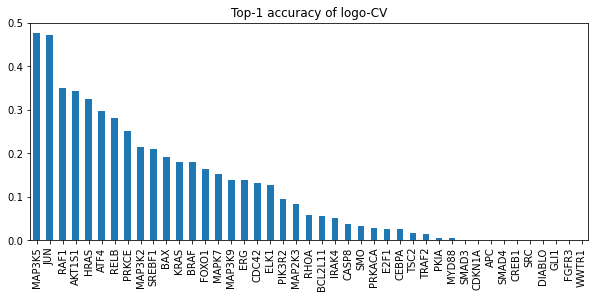

<IPython.core.display.Javascript object>

In [82]:
ax = logo_results_df.sort_values("top1", ascending=False).top1.plot(
    kind="bar", figsize=[10, 4]
)
ax.set_title("Top-1 accuracy of logo-CV")
plt.show()

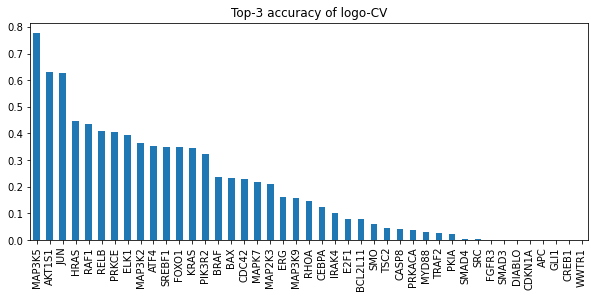

<IPython.core.display.Javascript object>

In [83]:
ax = logo_results_df.sort_values("top3", ascending=False).top3.plot(
    kind="bar", figsize=[10, 4]
)
ax.set_title("Top-3 accuracy of logo-CV")
plt.show()

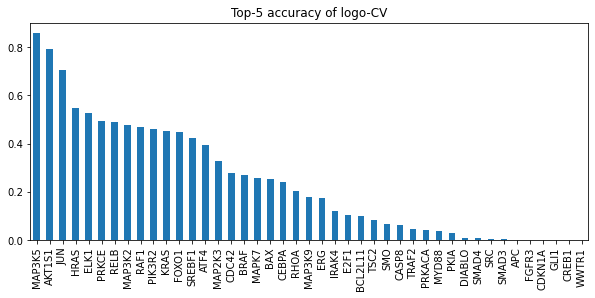

<IPython.core.display.Javascript object>

In [84]:
ax = logo_results_df.sort_values("top5", ascending=False).top5.plot(
    kind="bar", figsize=[10, 4]
)
ax.set_title("Top-5 accuracy of logo-CV")
plt.show()

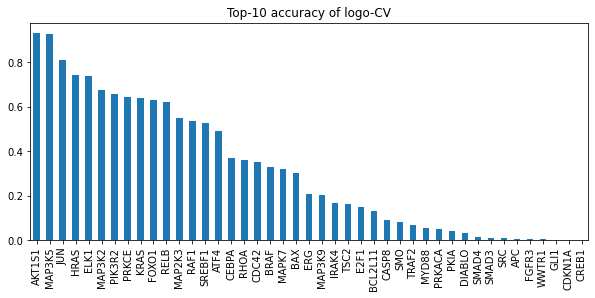

<IPython.core.display.Javascript object>

In [85]:
ax = logo_results_df.sort_values("top10", ascending=False).top10.plot(
    kind="bar", figsize=[10, 4]
)
ax.set_title("Top-10 accuracy of logo-CV")
plt.show()

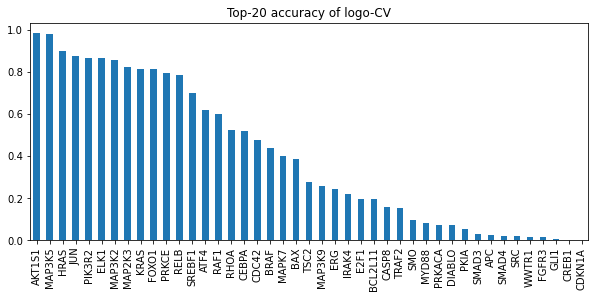

<IPython.core.display.Javascript object>

In [86]:
ax = logo_results_df.sort_values("top20", ascending=False).top20.plot(
    kind="bar", figsize=[10, 4]
)
ax.set_title("Top-20 accuracy of logo-CV")
plt.show()

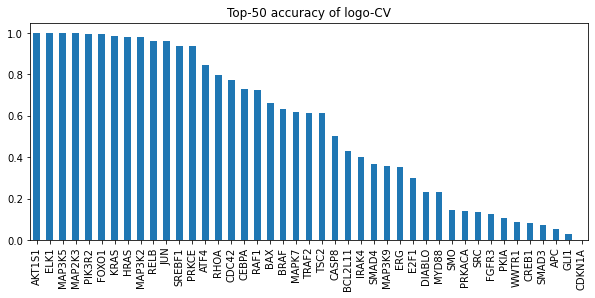

<IPython.core.display.Javascript object>

In [87]:
ax = logo_results_df.sort_values("top50", ascending=False).top50.plot(
    kind="bar", figsize=[10, 4]
)
ax.set_title("Top-50 accuracy of logo-CV")
plt.show()